In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime

plt.rcParams["figure.dpi"] = 120

In [67]:
LIFETIME_YEARS = 10                    # equipment lifetime in years
MANUFACTURING_ENERGY_KWH = 30000       # total manufacturing energy (kWh)
EOL_ENERGY_KWH = 2000                  # end-of-life processing energy (kWh)
BASE_POWER_KW = 5.0                    # average operational power draw (kW)
HOURS_PER_YEAR = 24 * 365
ANNUAL_OPERATIONAL_ENERGY_KWH = BASE_POWER_KW * HOURS_PER_YEAR

# Emission factors (kg CO2 per kWh) — replace with regional / paper values
GRID_EMISSION_FACTOR = 0.55            # baseline grid (kgCO2/kWh)
RENEWABLE_EMISSION_FACTOR = 0.05       # lifecycle emissions for renewable electricity (kgCO2/kWh)
RECYCLING_EMISSION_FACTOR = 0.30       # emission intensity for EoL/recycling energy use (kgCO2/kWh)

# Optimization params
DEFAULT_SLEEP_MODE_REDUCTION = 0.30    # 30% reduction in operational energy during sleep mode
DEFAULT_PARTIAL_RENEWABLE = 0.30       # 30% renewables in mixed-grid scenario

# Model options
manufacturing_spread = False            # True => amortize manufacturing over life; False => all at year 0
save_plots = True                      # whether to save PNG files
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
out_xlsx = f"5G_LCA_results_{timestamp}.xlsx"
out_plot_annual = f"CO2_annual_stacked_{timestamp}.png"
out_plot_cumulative = f"CO2_cumulative_{timestamp}.png"
out_plot_component = f"CO2_component_year_{timestamp}.png"
out_plot_savings = f"CO2_savings_analysis_{timestamp}.png"

print("Annual operational energy (kWh):", f"{ANNUAL_OPERATIONAL_ENERGY_KWH:,}")
print("Output Excel ->", out_xlsx)

Annual operational energy (kWh): 43,800.0
Output Excel -> 5G_LCA_results_20251129_165452.xlsx


In [68]:
years = np.arange(0, LIFETIME_YEARS + 1)   # 0..LIFETIME_YEARS inclusive

def emissions_from_energy(energy_kwh, ef):
    """Return kg CO2 given kWh and emission factor (kgCO2/kWh)."""
    return energy_kwh * ef

def build_scenario_df(name,
                      sleep_frac=0.0,
                      renewable_share=0.0,
                      manufacturing_spread_local=manufacturing_spread):
    """
    Build annual emissions DataFrame for a scenario.
    Parameters:
      - name: string
      - sleep_frac: fraction reduction in operational energy (0..1)
      - renewable_share: fraction of operational energy supplied by renewables (0..1)
      - manufacturing_spread_local: bool whether manufacturing energy is amortized
    Returns:
      Pandas DataFrame with columns:
        year, manufacturing_kgCO2, operational_kgCO2, eol_kgCO2, total_kgCO2, scenario
    """
    manuf = np.zeros_like(years, dtype=float)
    op = np.zeros_like(years, dtype=float)
    eol = np.zeros_like(years, dtype=float)

    # Manufacturing emissions
    if manufacturing_spread_local:
        annual_manufacturing_kwh = MANUFACTURING_ENERGY_KWH / LIFETIME_YEARS
        manuf[:] = emissions_from_energy(annual_manufacturing_kwh, GRID_EMISSION_FACTOR)
    else:
        # whole manufacturing emissions at year 0
        manuf[0] = emissions_from_energy(MANUFACTURING_ENERGY_KWH, GRID_EMISSION_FACTOR)

    # Operational emissions — compute effective emission factor
    ef_operational = renewable_share * RENEWABLE_EMISSION_FACTOR + (1.0 - renewable_share) * GRID_EMISSION_FACTOR
    for i, y in enumerate(years):
        op_energy = ANNUAL_OPERATIONAL_ENERGY_KWH * (1.0 - sleep_frac)
        op[i] = emissions_from_energy(op_energy, ef_operational)

    # End-of-life at final year
    eol[-1] = emissions_from_energy(EOL_ENERGY_KWH, RECYCLING_EMISSION_FACTOR)

    df = pd.DataFrame({
        "year": years,
        "manufacturing_kgCO2": manuf,
        "operational_kgCO2": op,
        "eol_kgCO2": eol
    })
    df["total_kgCO2"] = df[["manufacturing_kgCO2","operational_kgCO2","eol_kgCO2"]].sum(axis=1)
    df["scenario"] = name
    return df

In [69]:
scenarios_defs = {
    "baseline": {"sleep_frac": 0.0, "renewable_share": 0.0},
    "renewable": {"sleep_frac": 0.0, "renewable_share": 1.0},
    "mixed": {"sleep_frac": 0.0, "renewable_share": DEFAULT_PARTIAL_RENEWABLE},
    "sleep": {"sleep_frac": DEFAULT_SLEEP_MODE_REDUCTION, "renewable_share": 0.0},
    "sleep+renewable": {"sleep_frac": DEFAULT_SLEEP_MODE_REDUCTION, "renewable_share": 1.0},
}

list_df = []
for name, params in scenarios_defs.items():
    df_s = build_scenario_df(name,
                             sleep_frac=params["sleep_frac"],
                             renewable_share=params["renewable_share"],
                             manufacturing_spread_local=manufacturing_spread)
    list_df.append(df_s)

annual_results = pd.concat(list_df, ignore_index=True).sort_values(["scenario","year"])
cumulative_results = annual_results.copy()
cumulative_results["cumulative_total_kgCO2"] = cumulative_results.groupby("scenario")["total_kgCO2"].cumsum()
cumulative_results["cumulative_operational_kgCO2"] = cumulative_results.groupby("scenario")["operational_kgCO2"].cumsum()
cumulative_results["cumulative_manufacturing_kgCO2"] = cumulative_results.groupby("scenario")["manufacturing_kgCO2"].cumsum()
cumulative_results["cumulative_eol_kgCO2"] = cumulative_results.groupby("scenario")["eol_kgCO2"].cumsum()

summary_rows = []
for name in scenarios_defs.keys():
    df_s = annual_results[annual_results["scenario"] == name]
    summary_rows.append({
        "scenario": name,
        "manufacturing_life_kgCO2": df_s["manufacturing_kgCO2"].sum(),
        "operational_life_kgCO2": df_s["operational_kgCO2"].sum(),
        "eol_life_kgCO2": df_s["eol_kgCO2"].sum(),
        "total_life_kgCO2": df_s["total_kgCO2"].sum()
    })
summary_df = pd.DataFrame(summary_rows).set_index("scenario")

print("\nLifetime totals (kgCO2):")
print(summary_df["total_life_kgCO2"].sort_values())


Lifetime totals (kgCO2):
scenario
sleep+renewable     33963.0
renewable           41190.0
sleep              202593.0
mixed              209820.0
baseline           282090.0
Name: total_life_kgCO2, dtype: float64


In [70]:
with pd.ExcelWriter(out_xlsx, engine="openpyxl") as writer:
    annual_results.to_excel(writer, sheet_name="Annual_Results", index=False)
    cumulative_results.to_excel(writer, sheet_name="Cumulative_Results", index=False)
    summary_df.to_excel(writer, sheet_name="Lifetime_Summary")
print("Saved Excel:", out_xlsx)

Saved Excel: 5G_LCA_results_20251129_165452.xlsx


Saved annual line plot: CO2_annual_stacked_20251129_165452.png


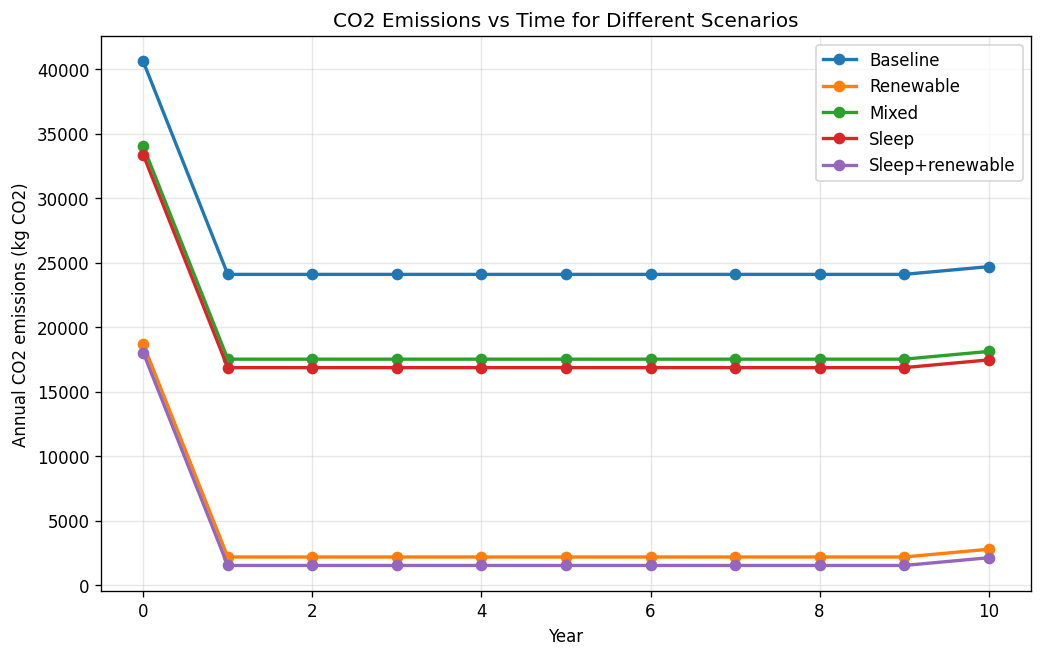

In [71]:
plt.figure(figsize=(10,6))

for name in scenarios_defs.keys():
    df_s = annual_results[annual_results["scenario"] == name]
    plt.plot(df_s["year"], df_s["total_kgCO2"],
             marker='o', linewidth=2,
             label=name.capitalize())

plt.xlabel("Year")
plt.ylabel("Annual CO2 emissions (kg CO2)")
plt.title("CO2 Emissions vs Time for Different Scenarios")
plt.grid(alpha=0.3)
plt.legend()

if save_plots:
    plt.savefig(out_plot_annual)
    print("Saved annual line plot:", out_plot_annual)

plt.show()

Saved cumulative plot: CO2_cumulative_20251129_165452.png


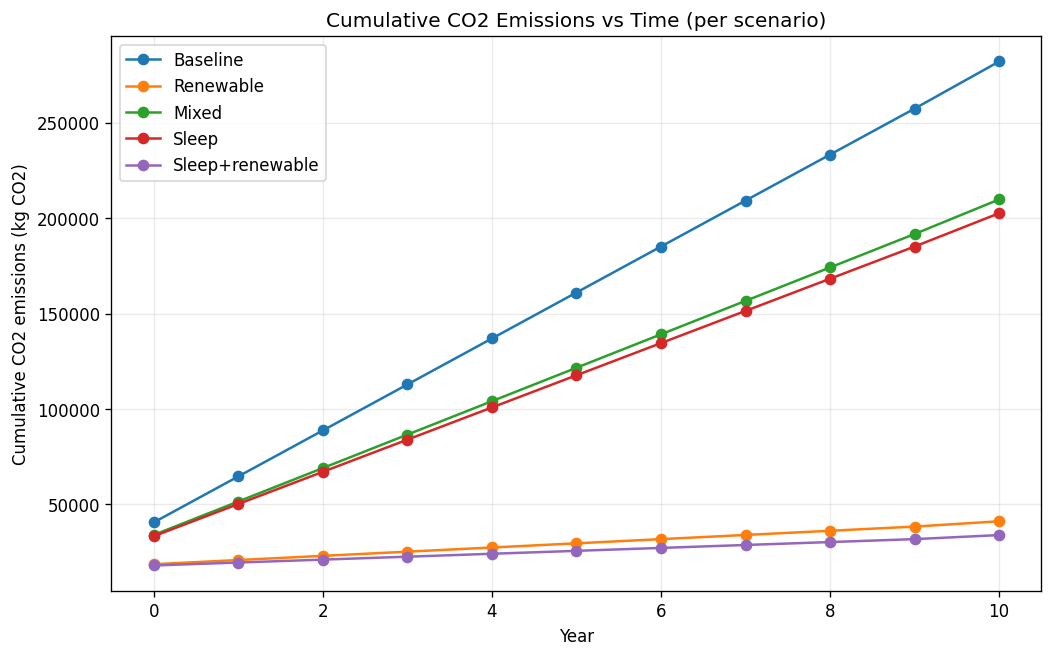

In [72]:
fig, ax = plt.subplots(figsize=(10,6))
for name in scenario_names:
    df_s = cumulative_results[cumulative_results["scenario"] == name]
    ax.plot(df_s["year"], df_s["cumulative_total_kgCO2"], marker='o', label=name.capitalize())
ax.set_xlabel("Year")
ax.set_ylabel("Cumulative CO2 emissions (kg CO2)")
ax.set_title("Cumulative CO2 Emissions vs Time (per scenario)")
ax.legend()
ax.grid(alpha=0.25)
if save_plots:
    plt.savefig(out_plot_cumulative)
    print("Saved cumulative plot:", out_plot_cumulative)
plt.show()

Saved bar-component plot: CO2_components_bars_20251129_165452.png


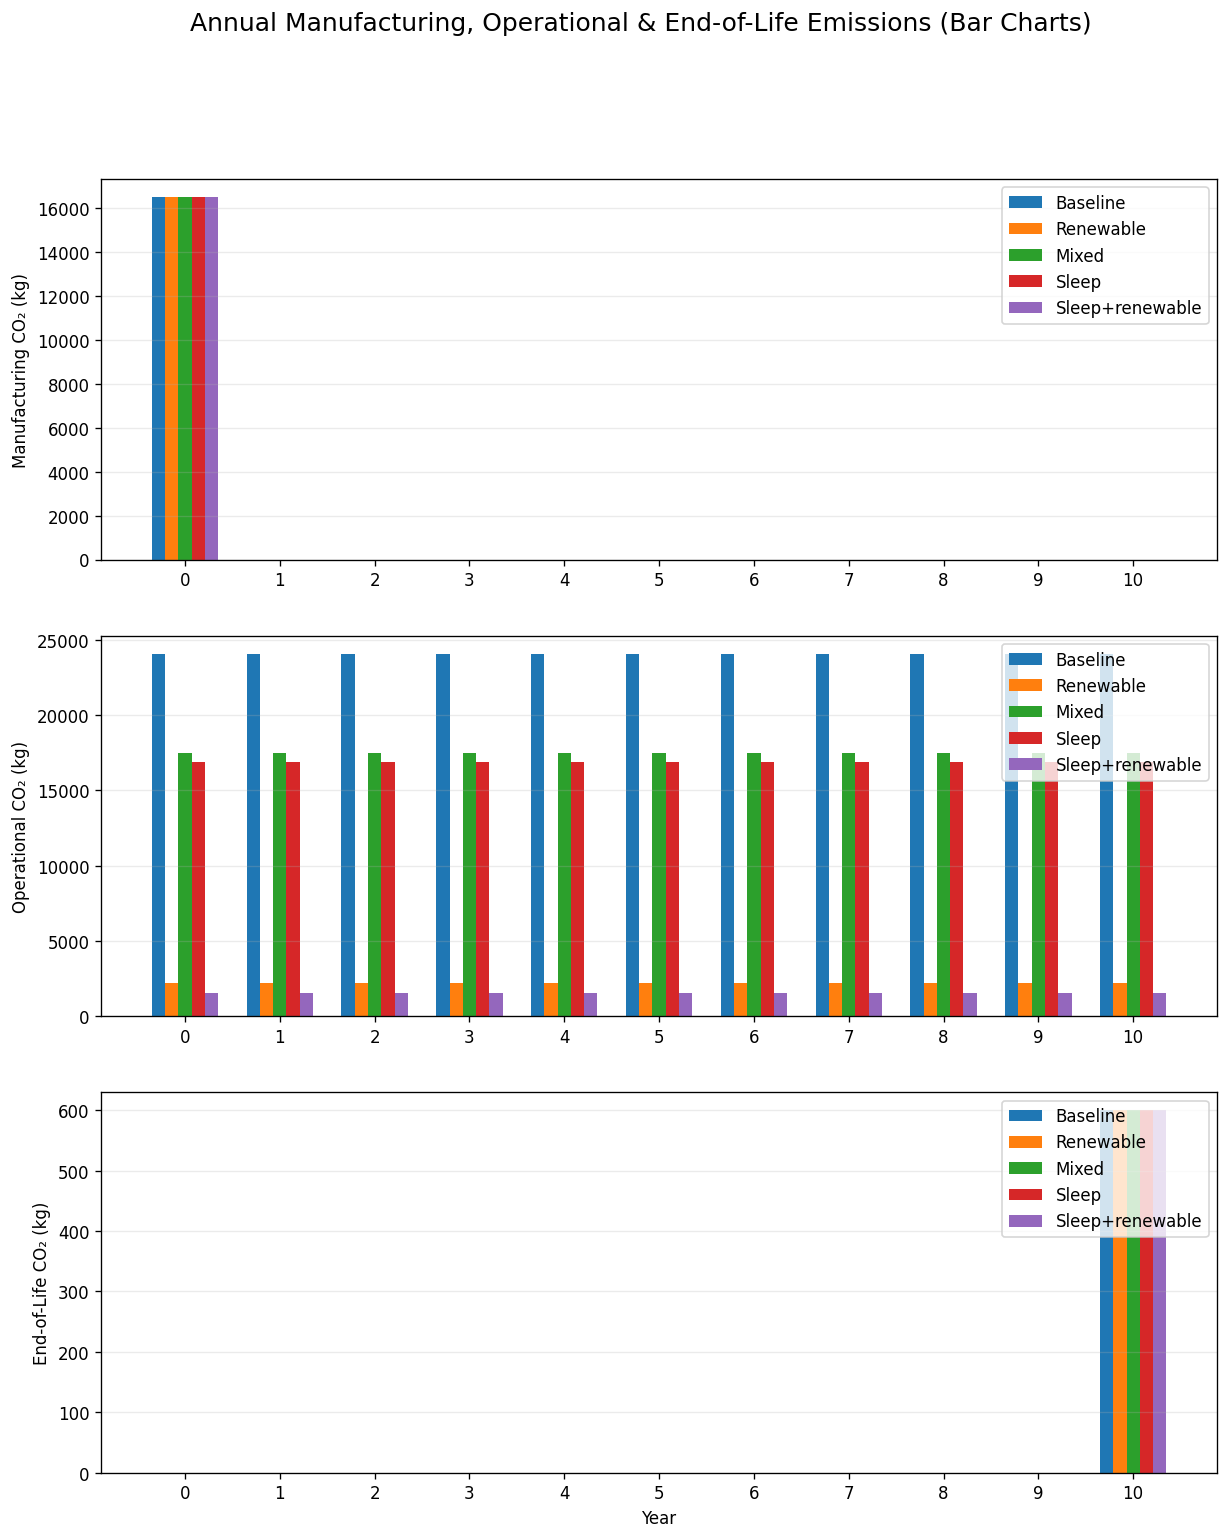

In [73]:
# %%
# Cell 7 (FIXED): Annual bar graphs for Manufacturing, Operational, and End-of-Life emissions
# Each subplot shows bars per scenario for each year, WITH year labels displayed on all subplots.
# NOTE: use sharex=False so each subplot shows its own x-axis labels.

fig, axes = plt.subplots(3, 1, figsize=(12, 14), sharex=False)

component_cols = [
    ("manufacturing_kgCO2", "Manufacturing CO₂ (kg)"),
    ("operational_kgCO2",  "Operational CO₂ (kg)"),
    ("eol_kgCO2",          "End-of-Life CO₂ (kg)")
]

scenario_names = list(scenarios_defs.keys())
n_scenarios = len(scenario_names)
bar_width = 0.14
x = np.arange(len(years))

for ax, (col, ylabel) in zip(axes, component_cols):
    for i, name in enumerate(scenario_names):
        df_s = annual_results[annual_results["scenario"] == name].set_index("year")
        values = df_s[col].reindex(years).values

        # Offset bars per scenario
        ax.bar(x + (i - n_scenarios/2) * bar_width + bar_width/2,
               values,
               width=bar_width,
               label=name.capitalize())

    # Ensure x-ticks and labels are shown on every subplot
    ax.set_xticks(x)
    ax.set_xticklabels(years, rotation=0)
    ax.tick_params(axis='x', which='both', labelbottom=True)

    ax.set_ylabel(ylabel)
    ax.grid(axis='y', alpha=0.25)
    ax.legend(loc="upper right")

# Bottom plot’s label
axes[-1].set_xlabel("Year")

fig.suptitle("Annual Manufacturing, Operational & End-of-Life Emissions (Bar Charts)", fontsize=15)

# Save plot
out_plot_components_all = f"CO2_components_bars_{timestamp}.png"
if save_plots:
    plt.savefig(out_plot_components_all)
    print("Saved bar-component plot:", out_plot_components_all)

plt.show()


Saved: CO2_baseline_stacked_20251129_165452.png


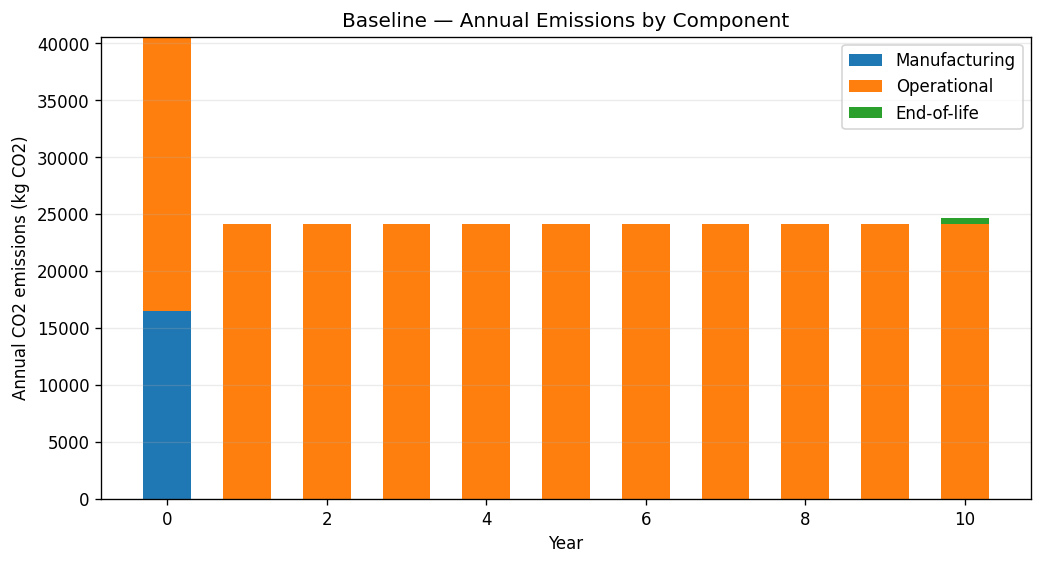

Saved: CO2_renewable_stacked_20251129_165452.png


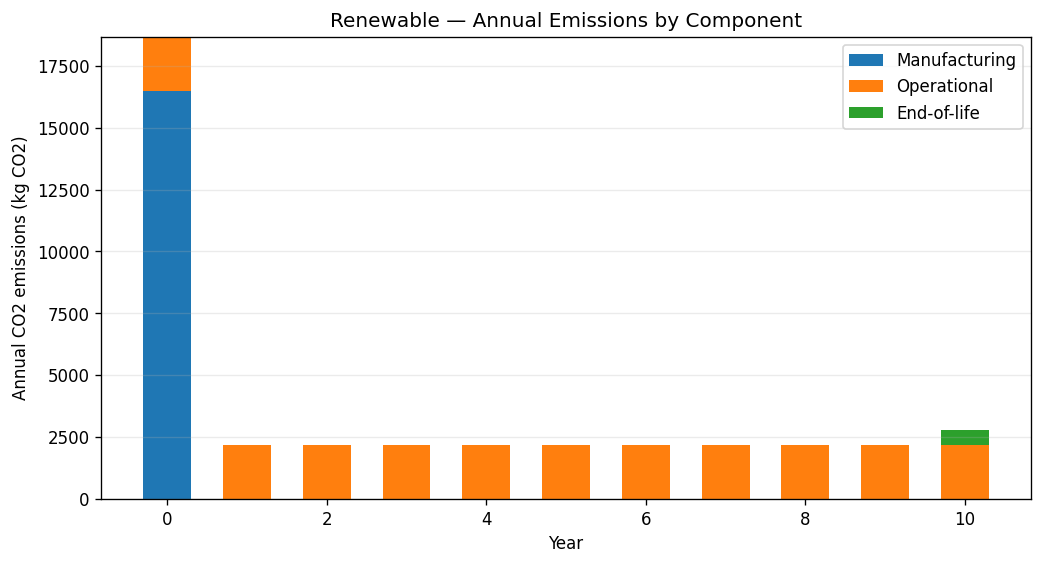

Saved: CO2_mixed_stacked_20251129_165452.png


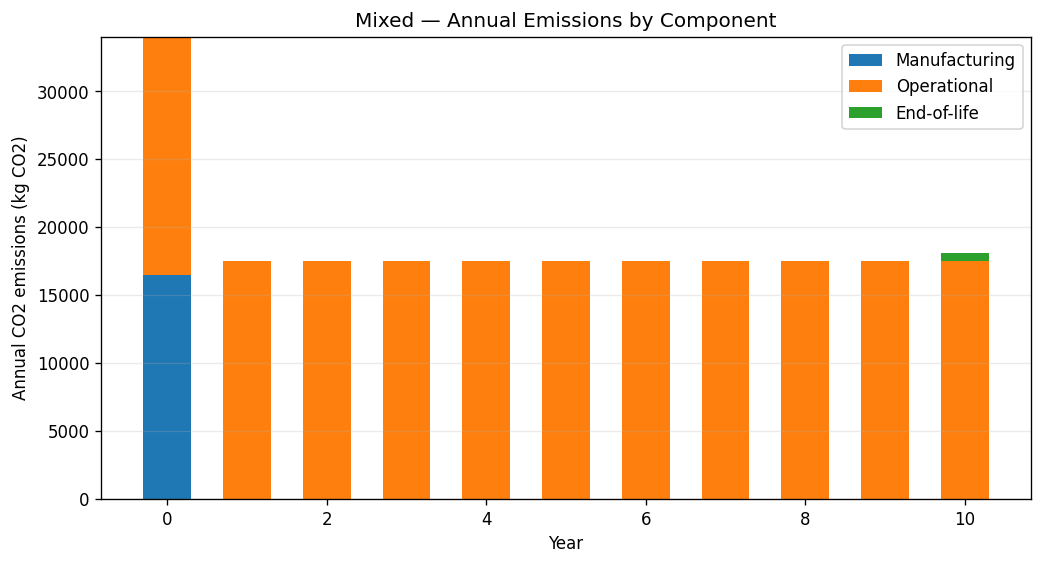

Saved: CO2_sleep_stacked_20251129_165452.png


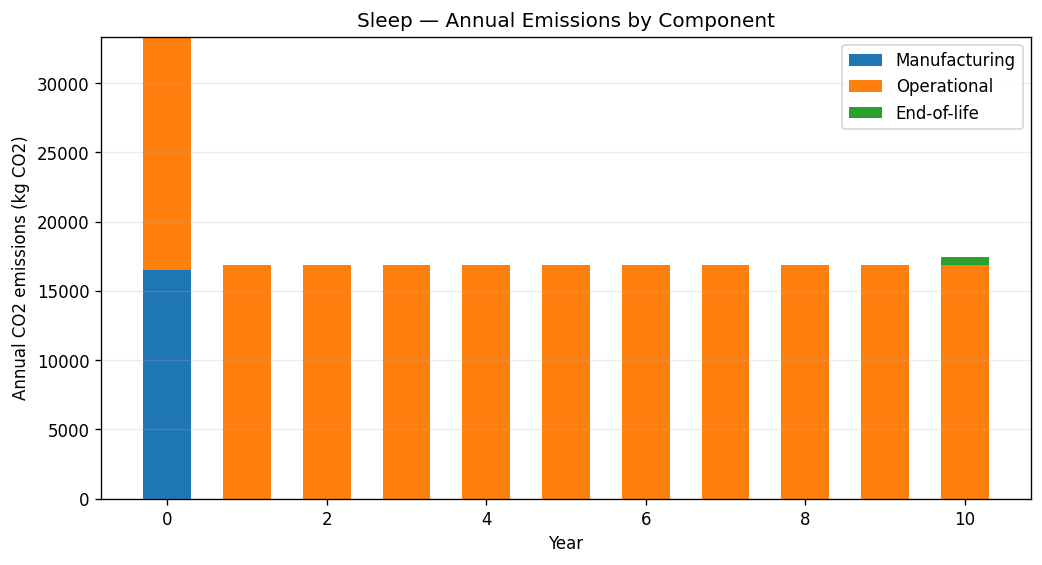

Saved: CO2_sleep+renewable_stacked_20251129_165452.png


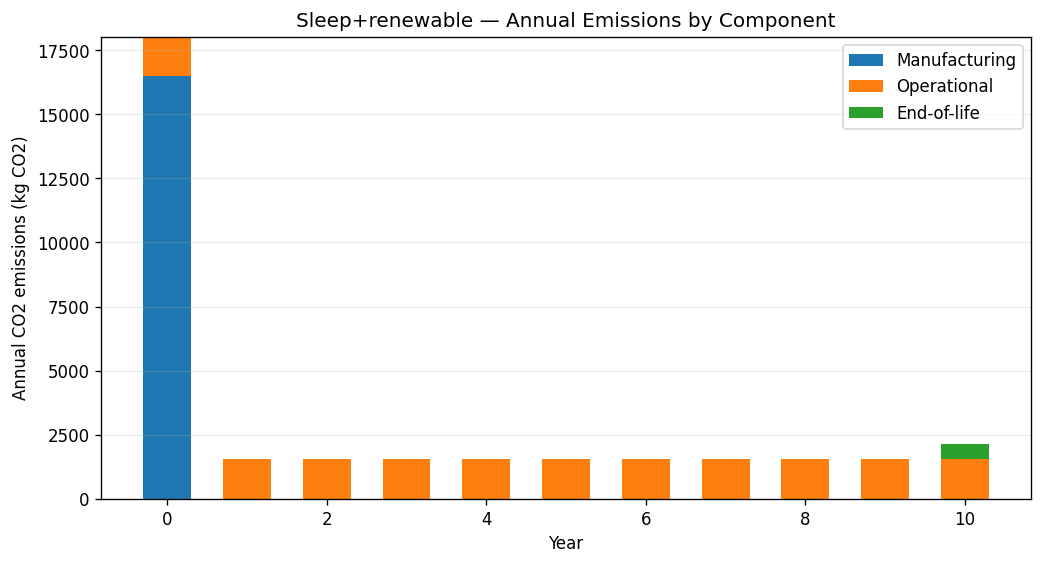

In [74]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

scenario_names = list(scenarios_defs.keys())
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # manufacturing, operational, eol
bar_width = 0.6

for name in scenario_names:
    df_s = annual_results[annual_results["scenario"] == name].set_index("year").reindex(years).fillna(0)
    manuf = df_s["manufacturing_kgCO2"].values
    oper = df_s["operational_kgCO2"].values
    eol = df_s["eol_kgCO2"].values

    fig, ax = plt.subplots(figsize=(10, 5))
    x = np.arange(len(years))

    p1 = ax.bar(x, manuf, width=bar_width, label="Manufacturing", color=colors[0])
    p2 = ax.bar(x, oper, width=bar_width, bottom=manuf, label="Operational", color=colors[1])
    p3 = ax.bar(x, eol, width=bar_width, bottom=manuf+oper, label="End-of-life", color=colors[2])

    ax.set_xticks(x)
    ax.set_xticklabels(years)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel("Year")
    ax.set_ylabel("Annual CO2 emissions (kg CO2)")
    ax.set_title(f"{name.capitalize()} — Annual Emissions by Component")
    ax.legend()
    ax.grid(axis="y", alpha=0.25)

    out_file = f"CO2_{name}_stacked_{timestamp}.png"
    if save_plots:
        plt.savefig(out_file)
        print("Saved:", out_file)
    plt.show()


Saved savings heatmap: CO2_savings_analysis_20251129_165452.png


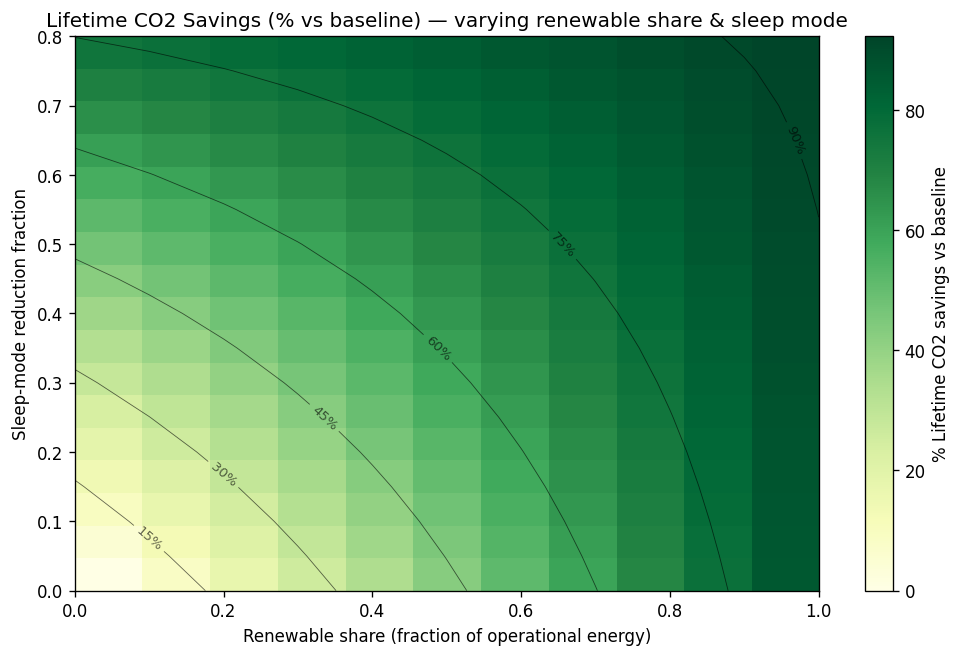


Baseline lifetime CO2 (kg): 282,090
Lifetime CO2 at default sleep=0.30, renewables=0.30: 152,004
Absolute savings (kg): 130,086  --> 46.1%


In [75]:
# We'll compute lifetime total CO2 for a grid of renewable_share (0..1) and sleep_frac (0..0.8)
renewable_shares = np.linspace(0.0, 1.0, 11)   # 0%, 10%, ..., 100%
sleep_fracs = np.linspace(0.0, 0.8, 17)        # 0%, 5%, ..., 80% sleep-mode reduction

# Compute baseline lifetime for comparison (no sleep, 0% renewable)
baseline_df = build_scenario_df("baseline", sleep_frac=0.0, renewable_share=0.0, manufacturing_spread_local=manufacturing_spread)
baseline_lifetime = baseline_df["total_kgCO2"].sum()

grid_lifetime = np.zeros((len(sleep_fracs), len(renewable_shares)))
for i, sf in enumerate(sleep_fracs):
    for j, rs in enumerate(renewable_shares):
        df_temp = build_scenario_df(f"temp_sf{sf}_rs{rs}", sleep_frac=sf, renewable_share=rs, manufacturing_spread_local=manufacturing_spread)
        grid_lifetime[i, j] = df_temp["total_kgCO2"].sum()

# Compute savings relative to baseline (%)
savings_pct = (baseline_lifetime - grid_lifetime) / baseline_lifetime * 100.0
savings_abs = baseline_lifetime - grid_lifetime  # kgCO2 saved

# Plot heatmap of % savings
fig, ax = plt.subplots(figsize=(10,6))
im = ax.imshow(savings_pct, aspect='auto', origin='lower',
               extent=[renewable_shares[0], renewable_shares[-1], sleep_fracs[0], sleep_fracs[-1]],
               cmap='YlGn')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('% Lifetime CO2 savings vs baseline')
ax.set_xlabel('Renewable share (fraction of operational energy)')
ax.set_ylabel('Sleep-mode reduction fraction')
ax.set_title('Lifetime CO2 Savings (% vs baseline) — varying renewable share & sleep mode')
# Add contour lines for readability
CS = ax.contour(renewable_shares, sleep_fracs, savings_pct, colors='k', linewidths=0.5, alpha=0.6)
ax.clabel(CS, inline=1, fontsize=8, fmt="%.0f%%")
if save_plots:
    plt.savefig(out_plot_savings)
    print("Saved savings heatmap:", out_plot_savings)
plt.show()

# Additionally, show slices: savings at default sleep fraction and default renewable share
default_sf = DEFAULT_SLEEP_MODE_REDUCTION
default_rs = DEFAULT_PARTIAL_RENEWABLE

# find nearest indices
idx_sf = np.abs(sleep_fracs - default_sf).argmin()
idx_rs = np.abs(renewable_shares - default_rs).argmin()
print(f"\nBaseline lifetime CO2 (kg): {baseline_lifetime:,.0f}")
print(f"Lifetime CO2 at default sleep={sleep_fracs[idx_sf]:.2f}, renewables={renewable_shares[idx_rs]:.2f}: {grid_lifetime[idx_sf, idx_rs]:,.0f}")
print(f"Absolute savings (kg): {savings_abs[idx_sf, idx_rs]:,.0f}  --> {savings_pct[idx_sf, idx_rs]:.1f}%")

In [76]:
savings_df = pd.DataFrame(savings_abs, index=np.round(sleep_fracs,3), columns=np.round(renewable_shares,3))
savings_df.index.name = "sleep_frac"
savings_df.columns.name = "renewable_share"
# append this as a sheet to the Excel file
with pd.ExcelWriter(out_xlsx, engine="openpyxl", mode="a") as writer:
    savings_df.to_excel(writer, sheet_name="Savings_kgCO2_grid")
print("Appended savings grid to Excel:", out_xlsx)


Appended savings grid to Excel: 5G_LCA_results_20251129_165452.xlsx


In [77]:
print("\nFiles created in current working directory:")
print(" - Excel:", out_xlsx)
print(" - Annual stacked plot:", out_plot_annual)
print(" - Cumulative plot:", out_plot_cumulative)
print(" - Component mix plot:", out_plot_component)
print(" - Savings heatmap:", out_plot_savings)


Files created in current working directory:
 - Excel: 5G_LCA_results_20251129_165452.xlsx
 - Annual stacked plot: CO2_annual_stacked_20251129_165452.png
 - Cumulative plot: CO2_cumulative_20251129_165452.png
 - Component mix plot: CO2_component_year_20251129_165452.png
 - Savings heatmap: CO2_savings_analysis_20251129_165452.png


Saved savings plot: CO2_savings_simple_20251129_165452.png


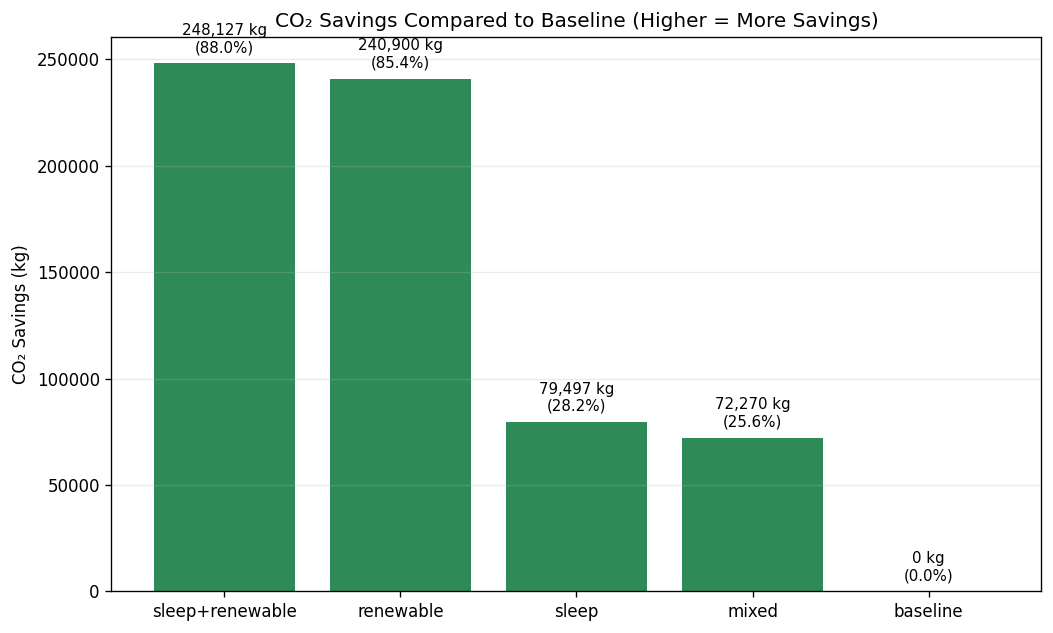

Added sorted savings table to Excel: 5G_LCA_results_20251129_165452.xlsx


In [78]:
compare_keys = ["baseline", "mixed", "renewable", "sleep", "sleep+renewable"]

# Compute lifetime totals
lifetime_totals = {}
for key in compare_keys:
    params = scenarios_defs.get(key)
    df_key = build_scenario_df(key,
                               sleep_frac=params["sleep_frac"],
                               renewable_share=params["renewable_share"],
                               manufacturing_spread_local=manufacturing_spread)
    lifetime_totals[key] = df_key["total_kgCO2"].sum()

baseline_total = lifetime_totals["baseline"]

# Compute savings
summary_rows = []
for k, val in lifetime_totals.items():
    savings_kg = baseline_total - val
    savings_pct = (savings_kg / baseline_total) * 100.0
    summary_rows.append({
        "scenario": k,
        "lifetime_total_kgCO2": val,
        "savings_kgCO2": savings_kg,
        "savings_pct": savings_pct
    })

savings_df = pd.DataFrame(summary_rows).set_index("scenario")

# Sort so highest savings is at the top
savings_df = savings_df.sort_values("savings_kgCO2", ascending=False)

# Plot: bar height = savings
fig, ax = plt.subplots(figsize=(10,6))

bars = ax.bar(savings_df.index,
              savings_df["savings_kgCO2"],
              color="seagreen")

# Annotate bars with values
for rect, scen in zip(bars, savings_df.index):
    height = rect.get_height()
    pct = savings_df.loc[scen, "savings_pct"]
    ax.annotate(f"{height:,.0f} kg\n({pct:.1f}%)",
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha="center", va="bottom", fontsize=9)

ax.set_ylabel("CO₂ Savings (kg)")
ax.set_title("CO₂ Savings Compared to Baseline (Higher = More Savings)")
ax.grid(axis="y", alpha=0.25)


out_plot_savings_simple = f"CO2_savings_simple_{timestamp}.png"
if save_plots:
    plt.savefig(out_plot_savings_simple)
    print("Saved savings plot:", out_plot_savings_simple)
plt.show()

# Save to Excel
with pd.ExcelWriter(out_xlsx, engine="openpyxl", mode="a") as writer:
    savings_df.to_excel(writer, sheet_name="Savings_Sorted")
print("Added sorted savings table to Excel:", out_xlsx)